## Global Config

In [1]:
download_from_remote = False
load_from_local = True
save_to_local = True

local_dataset = "./dataset/fever_dataset"
local_adversarial = "./dataset/adversarial_dataset"
%mkdir -p {local_dataset}
%mkdir -p {local_adversarial}

## Imports

In [2]:
# general imports
import os
import re
import string
import random

# visualization and statistics
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# data manipulation
import numpy as np
import pandas as pd
from typing import Dict
from datasets import load_dataset, load_from_disk

# nltk
import nltk
from nltk.corpus import wordnet as wn
nltk.download('wordnet')

# spacy
import spacy 
# Load the SpaCy model
nlp_spacy = spacy.load("en_core_web_sm")

# huggingface
from transformers import DataCollatorWithPadding
from transformers import (
    AutoTokenizer,
    set_seed,
)

# set seeds
set_seed(42)
np.random.seed(42)
random.seed(42)

/home/leeoos/miniconda3/envs/nlp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to /home/leeoos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data

In [8]:
# download data or just load from local 

if download_from_remote:
    # load chunk of FEVER datyaset
    fever_dataset = load_dataset("tommasobonomo/sem_augmented_fever_nli", trust_remote_code=True)

    # load adversarial 
    adversarial_testset = load_dataset("iperbole/adversarial_fever_nli", trust_remote_code=True)

    # structure of the dataset
    print(fever_dataset)

    if save_to_local:
        print(f"Save data in local {local_dataset}")
        fever_dataset.save_to_disk(local_dataset)
        print(f"Save adversarial dataset in {local_adversarial}")
        adversarial_testset.save_to_disk(local_adversarial)

elif load_from_local:
    print(f"Load data from local repository")
    fever_dataset = load_from_disk(local_dataset)
    adversarial_testset = load_from_disk(local_adversarial)
    
print("Done!")

Load data from local repository
Done!


## Exploration

In [3]:
# tokenization function for datapoint visualization

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

label_map = {
    'ENTAILMENT': 0,
    'NEUTRAL': 1,
    'CONTRADICTION': 2,
    'NOT ENOUGH INFO': None
}

def tokenize_function(examples):
    examples['label'] = [label_map[label] for label in examples['label']]
    return tokenizer(examples['premise'], examples['hypothesis'], padding=True, truncation=True)

In [6]:
# Exploration utils

def plot_labels_distribution(target_set, title=''):

    labels = [
        'ENTAILMENT',
        'NEUTRAL',
        'CONTRADICTION',
    ]


    label_counts = {}
    for label in target_set['label']:
        if label not in label_counts:
            label_counts[label] = 0
        label_counts[label] += 1

    plt.bar(labels, label_counts.values())
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title(f'Distribution of labels in {title}')
    plt.show()
    print()

    # # extract labels
    # labels = [item['label'] for item in target_set]

    # # count label frequencies
    # label_counts = Counter(labels)

    # # plotting the label distribution
    # plt.bar(label_counts.keys(), label_counts.values())
    # plt.title('Label Distribution')
    # plt.xlabel('Label')
    # plt.ylabel('Count')
    # plt.show()
        

def plot_lenghts_distribution(target_set, title='', compare_lenght=False):

    # extract premises and hypotheses
    premises = [item['premise'] for item in target_set ]
    hypotheses = [item['hypothesis'] for item in target_set]

    # compute lengths
    premise_lengths = [len(premise.split()) for premise in premises]
    hypothesis_lengths = [len(hypothesis.split()) for hypothesis in hypotheses]

    # plotting length distributions
    plt.figure(figsize=(8, 6))
    plt.hist(premise_lengths, bins=50, alpha=0.5, label='Premise', color='blue')
    plt.hist(hypothesis_lengths, bins=50, alpha=0.5, label='Hypothesis', color='green')
    plt.legend(loc='upper right')
    plt.title(f'Premise and Hypothesis Length Distribution in {title}')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')

    if compare_lenght:
        plt.figure(figsize=(8, 6))
        plt.scatter(premise_lengths, hypothesis_lengths, alpha=0.5)
        plt.title('Premise vs Hypothesis Length')
        plt.xlabel('Premise Length')
        plt.ylabel('Hypothesis Length')

    plt.show()


def plot_vocb_distribution():
    # Tokenize words
    # premise_words = [word for text in premises for word in word_tokenize(text)]
    # hypothesis_words = [word for text in hypotheses for word in word_tokenize(text)]

    # # Compute word frequencies
    # premise_word_freq = Counter(premise_words)
    # hypothesis_word_freq = Counter(hypothesis_words)

    # # Plotting the most common words
    # premise_common_words = premise_word_freq.most_common(20)
    # hypothesis_common_words = hypothesis_word_freq.most_common(20)

    # fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    # axes[0].barh([word[0] for word in premise_common_words], [word[1] for word in premise_common_words])
    # axes[0].set_title('Premise Common Words')
    # axes[1].barh([word[0] for word in hypothesis_common_words], [word[1] for word in hypothesis_common_words])
    # axes[1].set_title('Hypothesis Common Words')
    # plt.show()
    ...

# Prepare data for plotting
# lengths_and_labels = [(length, item['label']) for length, item in zip(premise_lengths, train_dataset)]
# premise_df = pd.DataFrame(lengths_and_labels, columns=['length', 'label'])

# lengths_and_labels = [(length, item['label']) for length, item in zip(hypothesis_lengths, train_dataset)]
# hypothesis_df = pd.DataFrame(lengths_and_labels, columns=['length', 'label'])

# # Plot premise lengths across classes
# plt.figure(figsize=(12, 6))
# sns.boxplot(x='label', y='length', data=premise_df)
# plt.title('Premise Length Distribution Across Classes')
# plt.show()

# # Plot hypothesis lengths across classes
# plt.figure(figsize=(12, 6))
# sns.boxplot(x='label', y='length', data=hypothesis_df)
# plt.title('Hypothesis Length Distribution Across Classes')
# plt.show()

# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity
# import numpy as np

# # Create combined list of premises and hypotheses
# texts = premises + hypotheses

# # Compute TF-IDF vectors
# tfidf = TfidfVectorizer().fit_transform(texts)

# # Compute cosine similarity between each premise and its corresponding hypothesis
# cosine_sim = [cosine_similarity(tfidf[i], tfidf[i + len(premises)])[0][0] for i in range(len(premises))]

# # Plot cosine similarity distribution
# plt.figure(figsize=(8, 6))
# plt.hist(cosine_sim, bins=50, alpha=0.5, color='purple')
# plt.title('Cosine Similarity Distribution Between Premise and Hypothesis')
# plt.xlabel('Cosine Similarity')
# plt.ylabel('Frequency')
# plt.show()




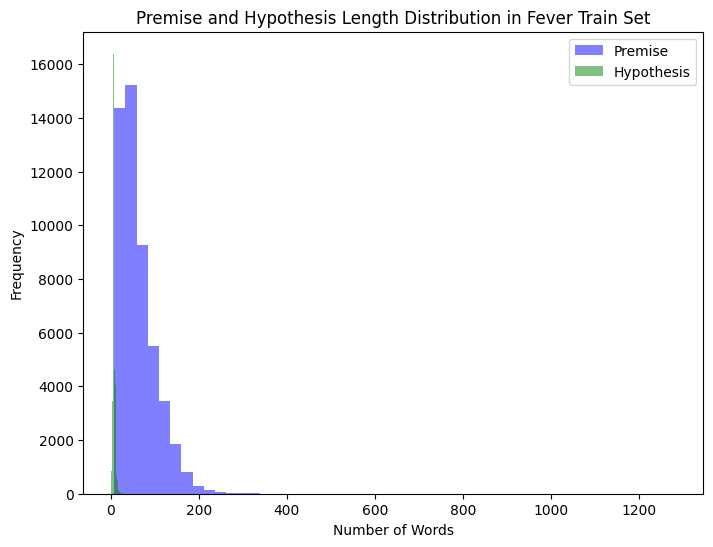

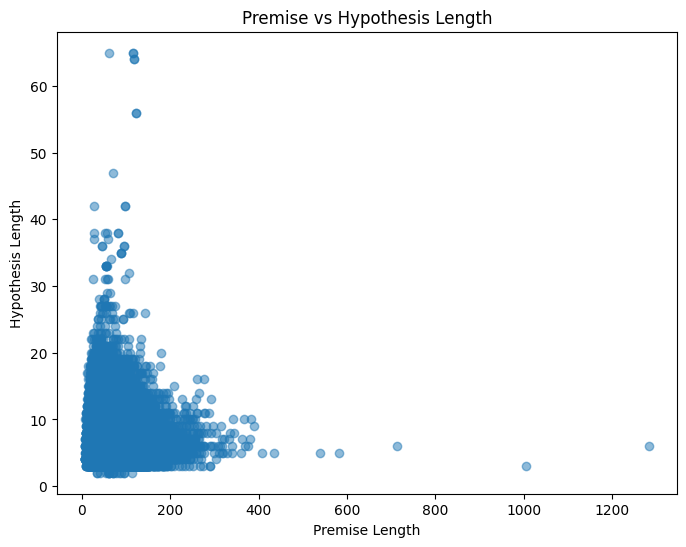

In [9]:
# statistics about the regular dataset
# plot_labels_distribution(fever_dataset['train'], title="Fever Train Set")
plot_lenghts_distribution(fever_dataset['train'], title="Fever Train Set", compare_lenght=True)

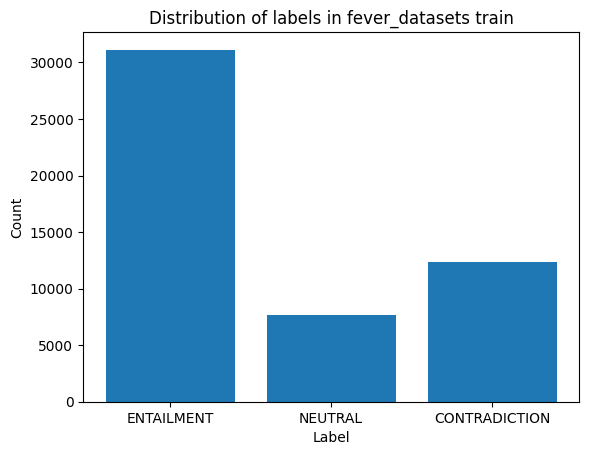

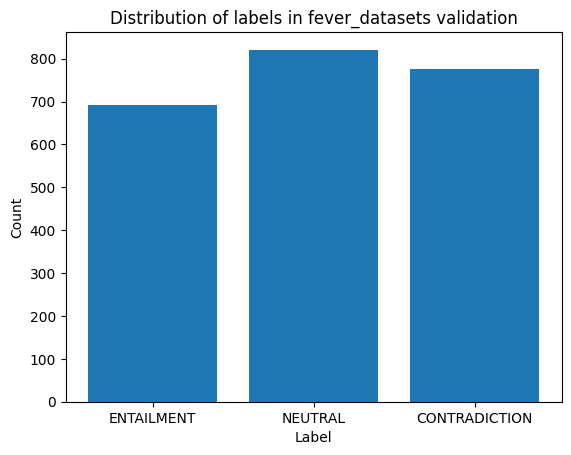

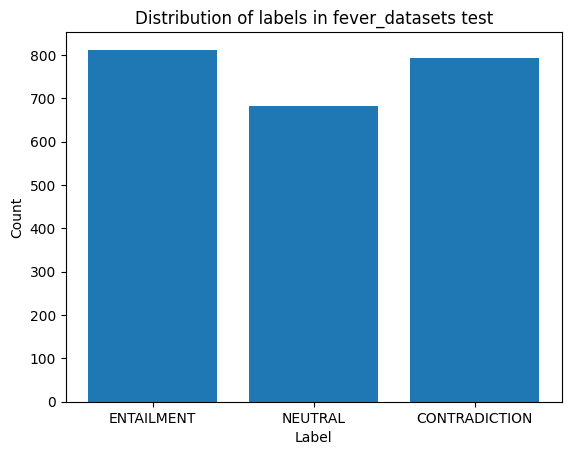

In [19]:
# labels = [
#     'ENTAILMENT',
#     'NEUTRAL',
#     'CONTRADICTION',
# ]

# for dataset_type in ['train', 'validation', 'test']:

#     label_counts = {}
#     for label in fever_dataset[dataset_type]['label']:
#         if label not in label_counts:
#             label_counts[label] = 0
#         label_counts[label] += 1

#     plt.bar(labels, label_counts.values())
#     plt.xlabel('Label')
#     plt.ylabel('Count')
#     plt.title(f'Distribution of labels in fever_datasets {dataset_type}')
#     plt.show()
#     print()

In [20]:
print(fever_dataset['train'][0]['srl'].keys())
print(fever_dataset['train'][0]['srl']['hypothesis']['tokens'])
print(fever_dataset['train'][0]['srl']['hypothesis']['annotations'])

dict_keys(['premise', 'hypothesis'])
[{'index': 0, 'rawText': 'Roman'}, {'index': 1, 'rawText': 'Atwood'}, {'index': 2, 'rawText': 'is'}, {'index': 3, 'rawText': 'a'}, {'index': 4, 'rawText': 'content'}, {'index': 5, 'rawText': 'creator'}, {'index': 6, 'rawText': '.'}]
[{'tokenIndex': 2, 'verbatlas': {'frameName': 'COPULA', 'roles': [{'role': 'Theme', 'score': 1.0, 'span': [0, 2]}, {'role': 'Attribute', 'score': 1.0, 'span': [3, 6]}]}, 'englishPropbank': {'frameName': 'be.01', 'roles': [{'role': 'ARG1', 'score': 1.0, 'span': [0, 2]}, {'role': 'ARG2', 'score': 1.0, 'span': [3, 6]}]}}]


In [5]:
print(fever_dataset['train'][0]['premise'])

Roman Atwood . He is best known for his vlogs , where he posts updates about his life on a daily basis . His vlogging channel , `` RomanAtwoodVlogs '' , has a total of 3.3 billion views and 11.9 million subscribers . He also has another YouTube channel called `` RomanAtwood '' , where he posts pranks .


In [6]:
for token in fever_dataset['train'][0]['srl']['premise']['tokens']:
    print(token)

{'index': 0, 'rawText': 'Roman'}
{'index': 1, 'rawText': 'Atwood'}
{'index': 2, 'rawText': '.'}
{'index': 3, 'rawText': 'He'}
{'index': 4, 'rawText': 'is'}
{'index': 5, 'rawText': 'best'}
{'index': 6, 'rawText': 'known'}
{'index': 7, 'rawText': 'for'}
{'index': 8, 'rawText': 'his'}
{'index': 9, 'rawText': 'vlogs'}
{'index': 10, 'rawText': ','}
{'index': 11, 'rawText': 'where'}
{'index': 12, 'rawText': 'he'}
{'index': 13, 'rawText': 'posts'}
{'index': 14, 'rawText': 'updates'}
{'index': 15, 'rawText': 'about'}
{'index': 16, 'rawText': 'his'}
{'index': 17, 'rawText': 'life'}
{'index': 18, 'rawText': 'on'}
{'index': 19, 'rawText': 'a'}
{'index': 20, 'rawText': 'daily'}
{'index': 21, 'rawText': 'basis'}
{'index': 22, 'rawText': '.'}
{'index': 23, 'rawText': 'His'}
{'index': 24, 'rawText': 'vlogging'}
{'index': 25, 'rawText': 'channel'}
{'index': 26, 'rawText': ','}
{'index': 27, 'rawText': '`'}
{'index': 28, 'rawText': '`'}
{'index': 29, 'rawText': 'RomanAtwoodVlogs'}
{'index': 30, 'rawTex

In [7]:
for annotation in fever_dataset['train'][0]['srl']['premise']['annotations']:
    for key, value in annotation.items():
        print(f"{key}:\t{value}")
    print()

tokenIndex:	4
verbatlas:	{'frameName': 'COPULA', 'roles': [{'role': 'Theme', 'score': 1.0, 'span': [3, 4]}, {'role': 'Attribute', 'score': 1.0, 'span': [5, 22]}]}
englishPropbank:	{'frameName': 'be.01', 'roles': [{'role': 'ARG1', 'score': 1.0, 'span': [3, 4]}, {'role': 'ARG2', 'score': 1.0, 'span': [5, 22]}]}

tokenIndex:	6
verbatlas:	{'frameName': 'KNOW', 'roles': [{'role': 'Theme', 'score': 1.0, 'span': [3, 4]}, {'role': 'Attribute', 'score': 1.0, 'span': [5, 6]}, {'role': 'Topic', 'score': 1.0, 'span': [7, 22]}]}
englishPropbank:	{'frameName': 'know.01', 'roles': [{'role': 'ARG1', 'score': 1.0, 'span': [3, 4]}, {'role': 'ARGM-MNR', 'score': 1.0, 'span': [5, 6]}, {'role': 'ARG2', 'score': 1.0, 'span': [7, 22]}]}

tokenIndex:	13
verbatlas:	{'frameName': 'RECORD', 'roles': [{'role': 'Location', 'score': 1.0, 'span': [8, 10]}, {'role': 'Agent', 'score': 1.0, 'span': [12, 13]}, {'role': 'Theme', 'score': 1.0, 'span': [14, 18]}, {'role': 'Time', 'score': 1.0, 'span': [18, 22]}]}
englishPr

In [8]:
fever_dataset['train'][0:2]['srl']

[{'premise': {'tokens': [{'index': 0, 'rawText': 'Roman'},
    {'index': 1, 'rawText': 'Atwood'},
    {'index': 2, 'rawText': '.'},
    {'index': 3, 'rawText': 'He'},
    {'index': 4, 'rawText': 'is'},
    {'index': 5, 'rawText': 'best'},
    {'index': 6, 'rawText': 'known'},
    {'index': 7, 'rawText': 'for'},
    {'index': 8, 'rawText': 'his'},
    {'index': 9, 'rawText': 'vlogs'},
    {'index': 10, 'rawText': ','},
    {'index': 11, 'rawText': 'where'},
    {'index': 12, 'rawText': 'he'},
    {'index': 13, 'rawText': 'posts'},
    {'index': 14, 'rawText': 'updates'},
    {'index': 15, 'rawText': 'about'},
    {'index': 16, 'rawText': 'his'},
    {'index': 17, 'rawText': 'life'},
    {'index': 18, 'rawText': 'on'},
    {'index': 19, 'rawText': 'a'},
    {'index': 20, 'rawText': 'daily'},
    {'index': 21, 'rawText': 'basis'},
    {'index': 22, 'rawText': '.'},
    {'index': 23, 'rawText': 'His'},
    {'index': 24, 'rawText': 'vlogging'},
    {'index': 25, 'rawText': 'channel'},
    {


## Augmentation
The following prompt can be used to correct the grammar of a modified hypotesis so if just a not is added the phrase is transformed in negative form:
Correct the grammar in the following inputs, rephrase the input if necessary to make them more accurate. Provide just the correct version, no explanation.


In [15]:
sample_range = 10

for i in range(sample_range):
    data = fever_dataset['train'][i]

    # premise
    sentence = data['premise']

    # wsd
    wsd =  data['wsd']

    # srl
    possible_locations = set()
    tokens = data['srl']['premise']['tokens']
    annotations = data['srl']['premise']['annotations']
    # print(tokens)

    for annotation in annotations:
        # print(annotation['verbatlas']['roles'])
        # print(annotation)
        roles = annotation['verbatlas']['roles']
        index = annotation['verbatlas']

        # print(index)
        for role in roles:
            # print(role)
            if role['role'] == 'Location':
                span = role['span']
                filtered_texts = [item['rawText'] for item in tokens if span[0] <= item['index'] <= span[1]]
                filtered_words = [word for word in filtered_texts if any(char.isupper() for char in word)]
                if filtered_words:
                    new_set = set(filtered_words)
                    possible_locations.update(new_set)

    print()

    if possible_locations: print(possible_locations)
    filtered_locations = {word for word in possible_locations if any(ent.label_ == "GPE" for ent in nlp_spacy(word).ents)}
    if filtered_locations: print(filtered_locations)


    


{'RomanAtwood', 'YouTube'}
set()

{'NHL', 'Garden', 'TD', 'Bruins', 'National', 'League', 'Hockey', 'Boston'}
{'Boston'}

set()
set()

set()
set()

set()
set()

{'Billboard', 'Awards', 'Grammy'}
set()

{'Billboard', 'Awards', 'Grammy'}
set()

{'Billboard', 'Awards', 'Grammy'}
set()

{'Billboard', 'Awards', 'Grammy'}
set()

{'Los', 'Angeles', 'United', 'States'}
{'States'}


In [ ]:
# add new samples to the dataset
filtered_dataset = fever_dataset['train'].filter(lambda example: 'born' in example['premise'].lower() or 'born' in example['hypothesis'].lower())

In [ ]:
# from transformers import pipeline

# # Load the NER pipeline
# nlp = pipeline("ner")

# # Example sentence
# sentence = "Los Angeles is a city in the United States."

# # Process the sentence
# ner_results = nlp(sentence)

# # Extract GPE entities
# geographic_locations = {result['word'] for result in ner_results if result['entity'] == 'B-LOC' or result['entity'] == 'I-LOC'}

# print(geographic_locations)
